In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For time series operations and modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("deep")
sns.set_context("notebook", font_scale=1.2)

In [4]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.columns = ['Passengers']

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
df.head()

Dataset shape: (144, 1)
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Exploratory Data Analysis (EDA)

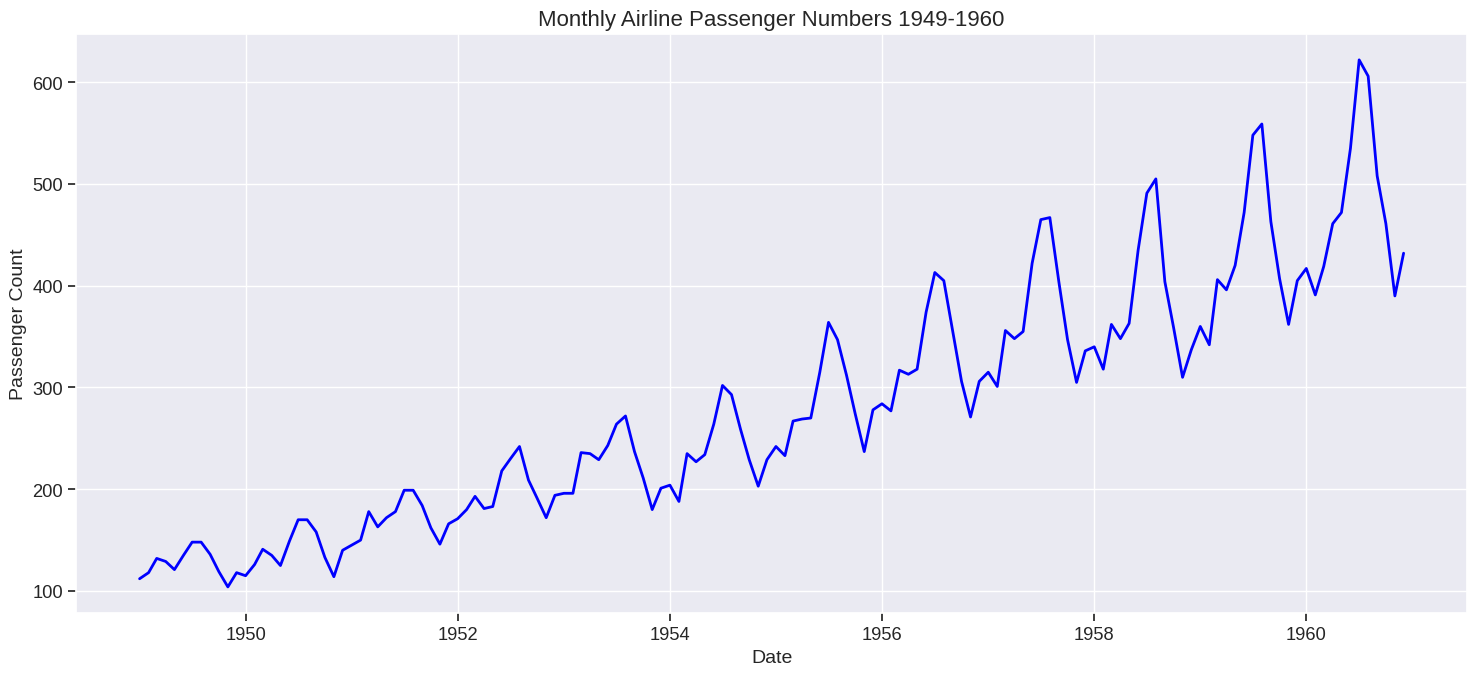

In [5]:
# Plot the time series
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['Passengers'], color='blue', linewidth=2)
plt.title('Monthly Airline Passenger Numbers 1949-1960', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Passenger Count', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
print("Summary Statistics:")
display(df.describe())

Summary Statistics:


,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
# Check for missing values
print(f"\nMissing values: {df.isnull().sum()[0]}")


Missing values: 0


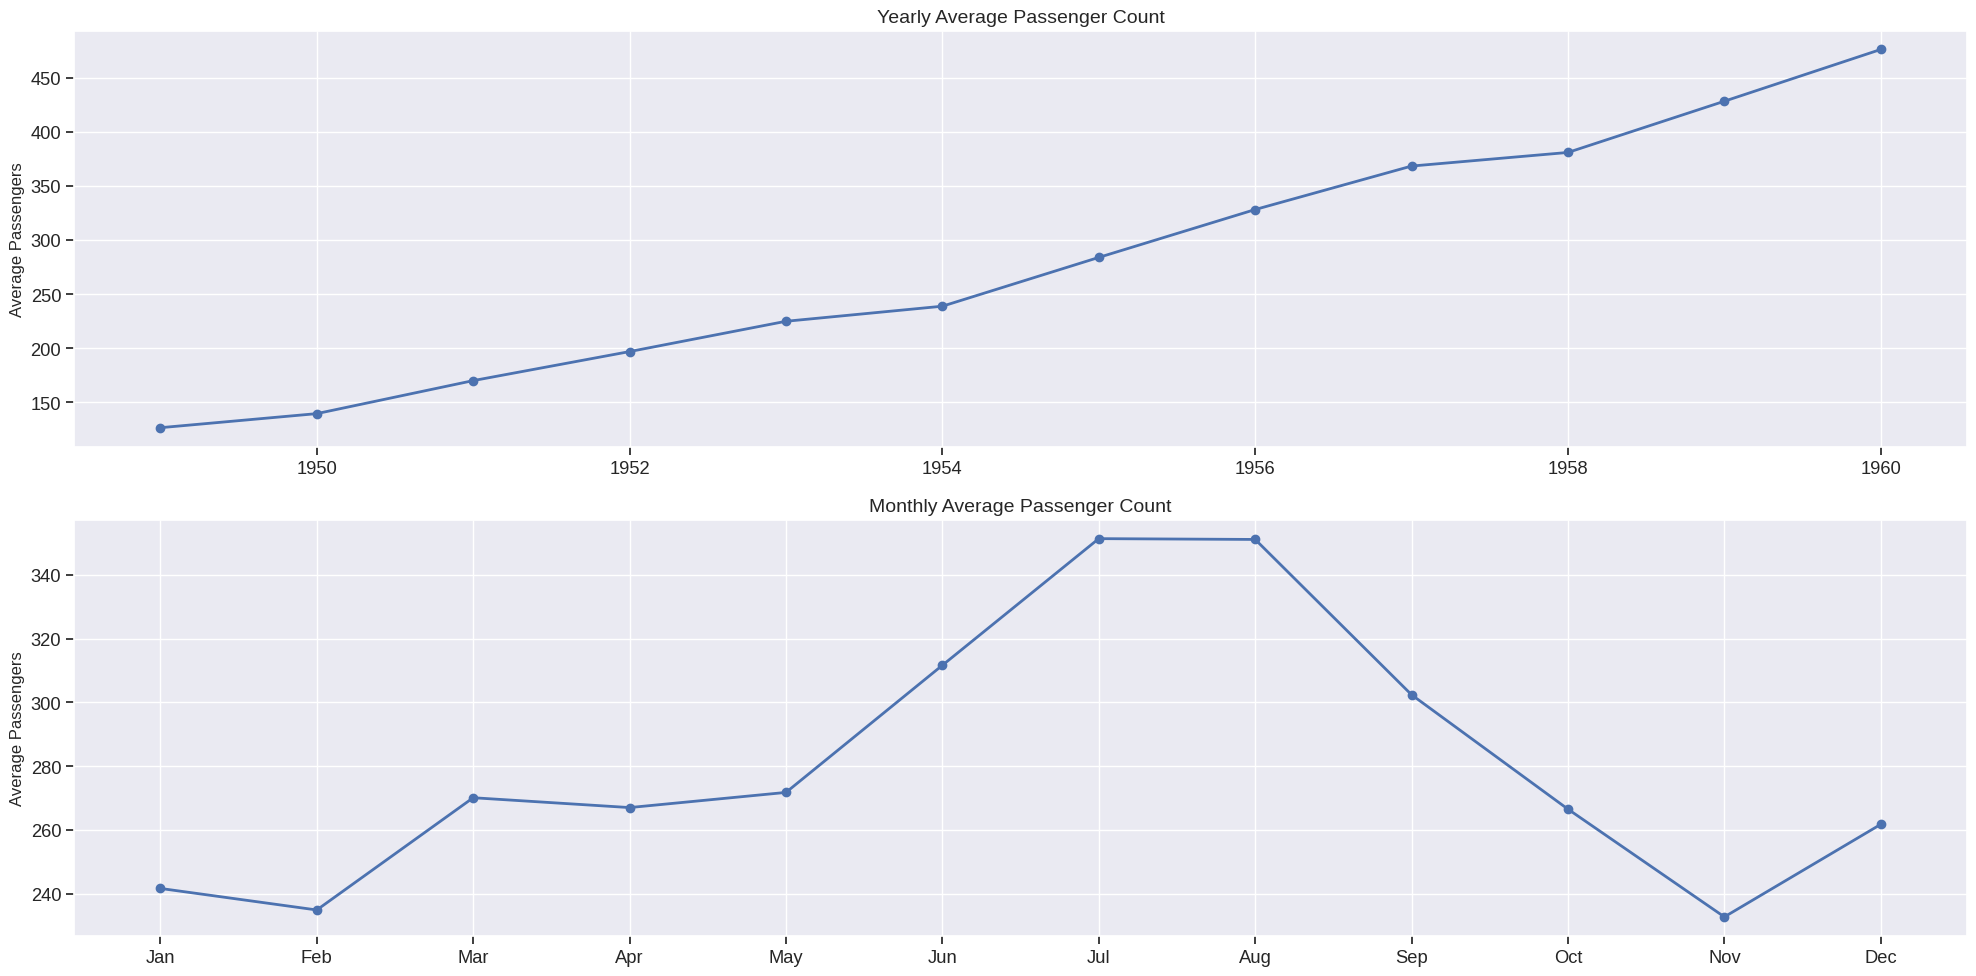

In [8]:
# Visualize yearly and monthly patterns
plt.figure(figsize=(20, 10))

# Yearly patterns
plt.subplot(2, 1, 1)
yearly_avg = df.resample('Y').mean()
plt.plot(yearly_avg.index.year, yearly_avg['Passengers'], 'o-', linewidth=2)
plt.title('Yearly Average Passenger Count', fontsize=14)
plt.ylabel('Average Passengers', fontsize=12)
plt.grid(True)

# Monthly patterns
plt.subplot(2, 1, 2)
monthly_avg = df.groupby(df.index.month).mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(months, monthly_avg['Passengers'], 'o-', linewidth=2)
plt.title('Monthly Average Passenger Count', fontsize=14)
plt.ylabel('Average Passengers', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

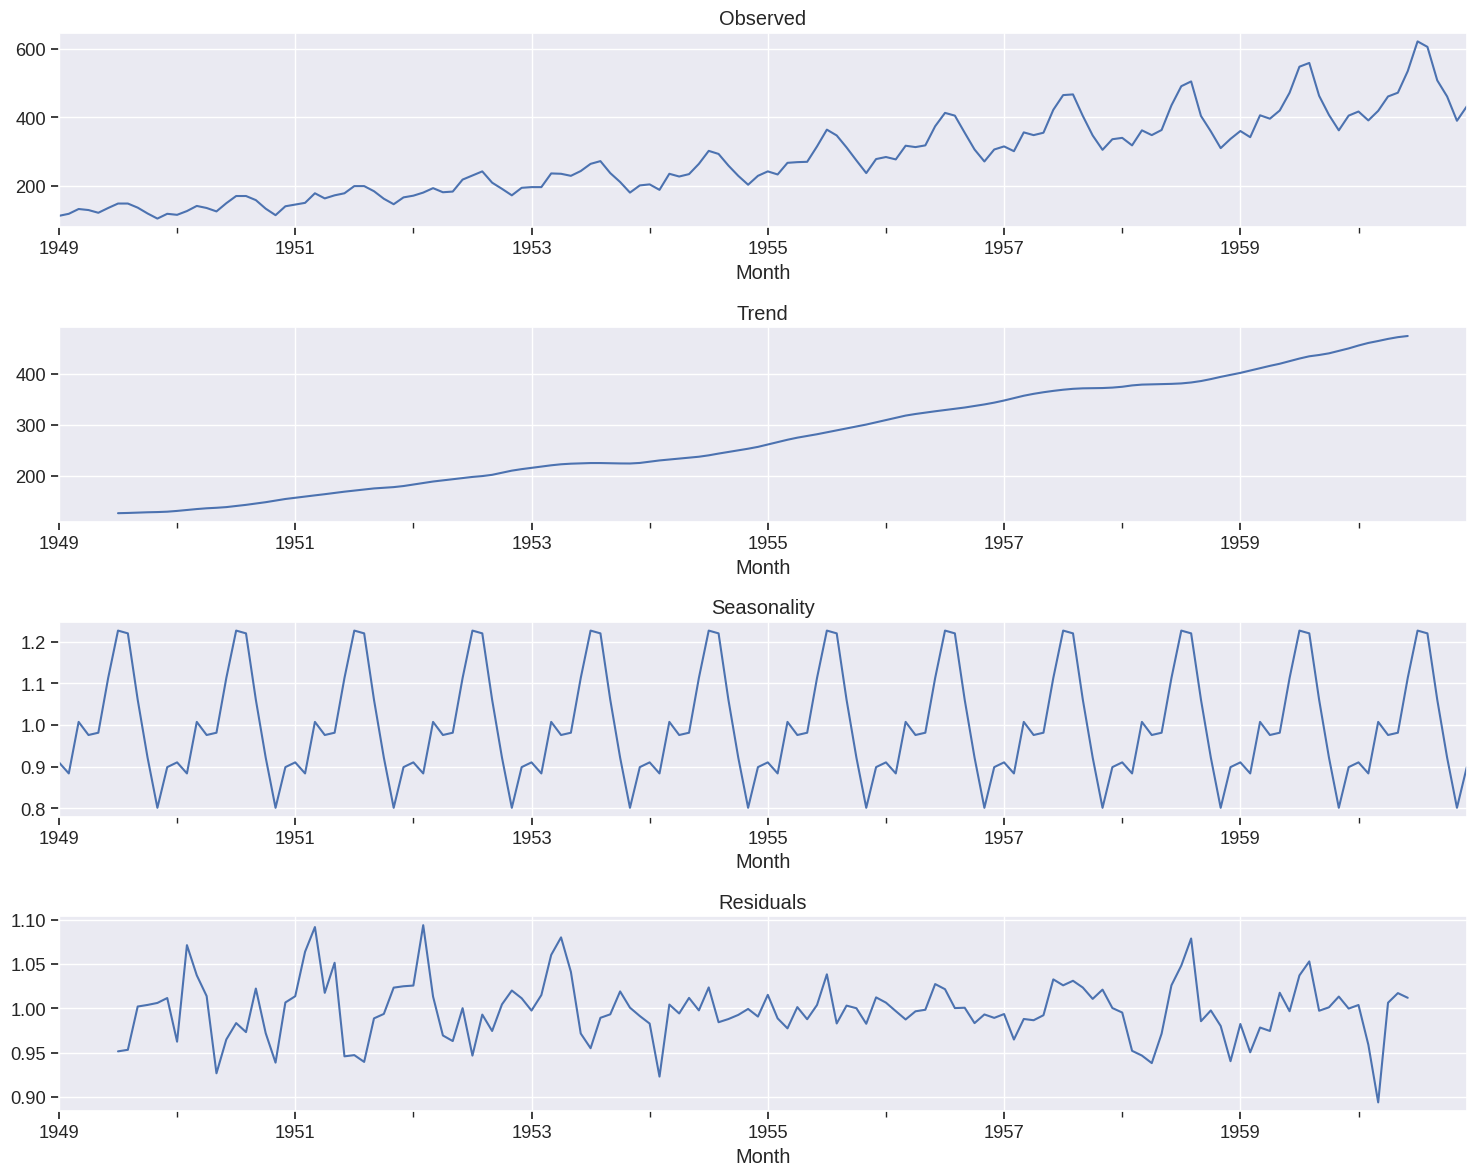

In [9]:
# Time series decomposition
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonality')
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residuals')
plt.tight_layout()
plt.show()

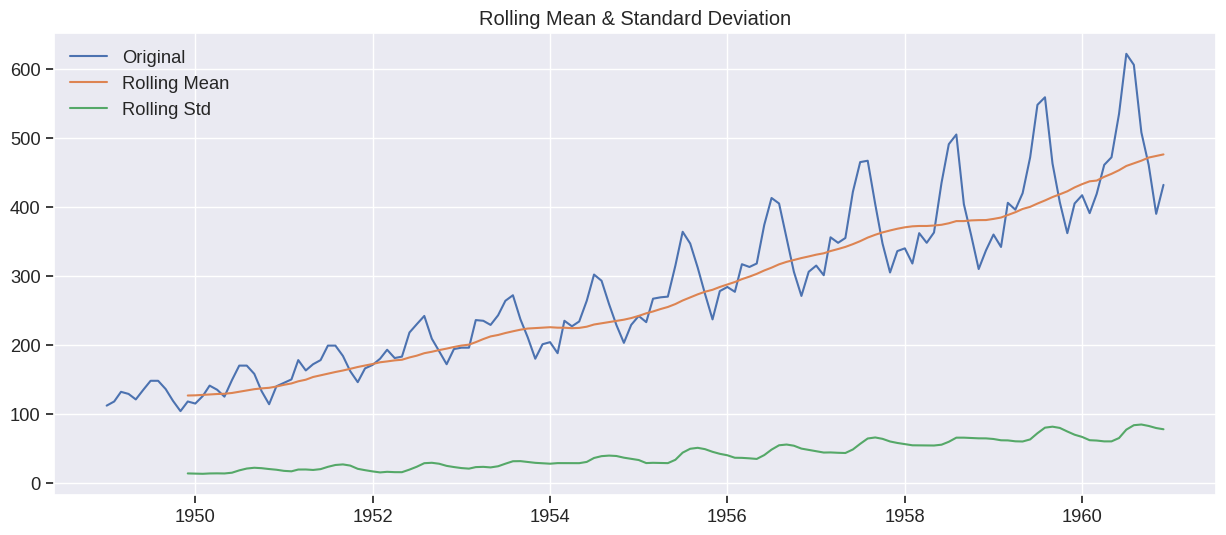

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Conclusion: The series is not stationary


In [11]:
# Check stationarity with Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(15, 6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perform Augmented Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Print conclusion
    if dftest[1] <= 0.05:
        print("\nConclusion: The series is stationary")
    else:
        print("\nConclusion: The series is not stationary")

check_stationarity(df['Passengers'])

In [12]:
# Apply differencing to make the series stationary
df_diff = df.copy()
df_diff['Passengers_diff'] = df_diff['Passengers'].diff()
df_diff = df_diff.dropna()

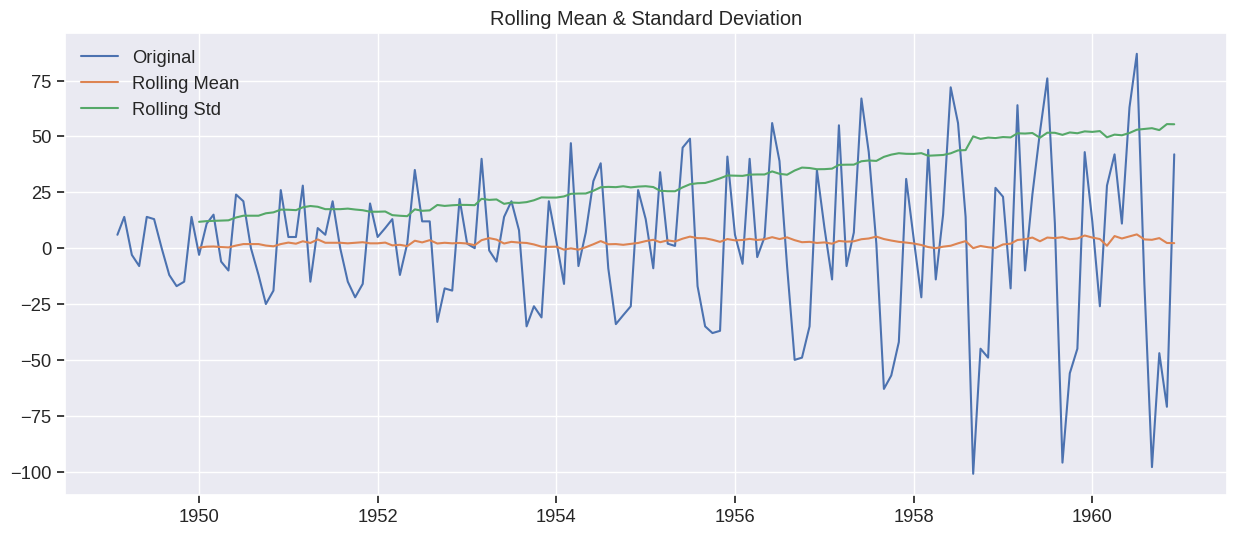

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

Conclusion: The series is not stationary


In [13]:
# Check stationarity of the differenced series
check_stationarity(df_diff['Passengers_diff'])

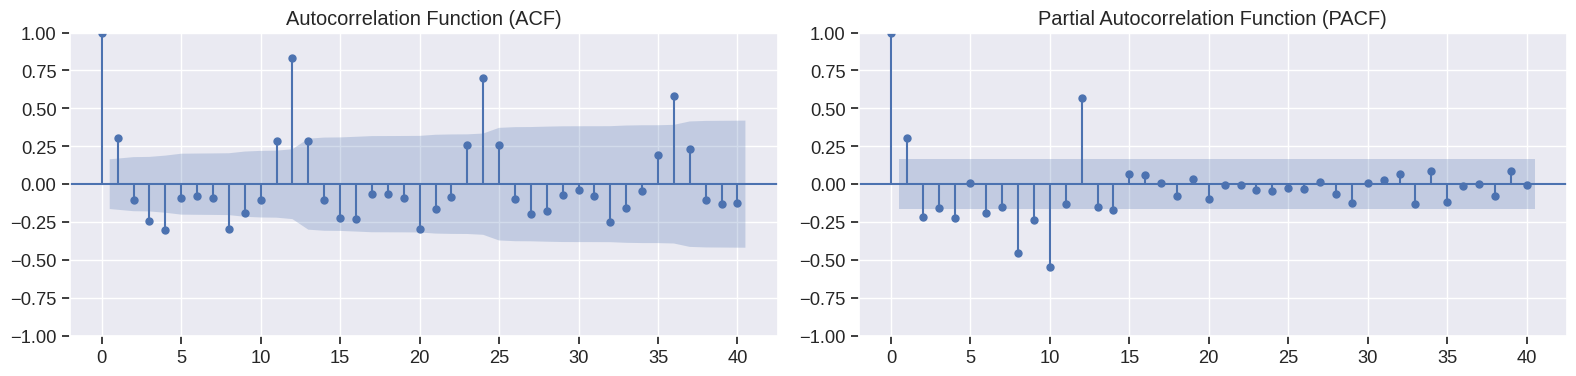

In [14]:
# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Plot ACF
plot_acf(df_diff['Passengers_diff'].dropna(), ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(df_diff['Passengers_diff'].dropna(), ax=axes[1], lags=40)
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Training data: 1949-01-01 00:00:00 to 1958-07-01 00:00:00 (115 months)
Testing data: 1958-08-01 00:00:00 to 1960-12-01 00:00:00 (29 months)


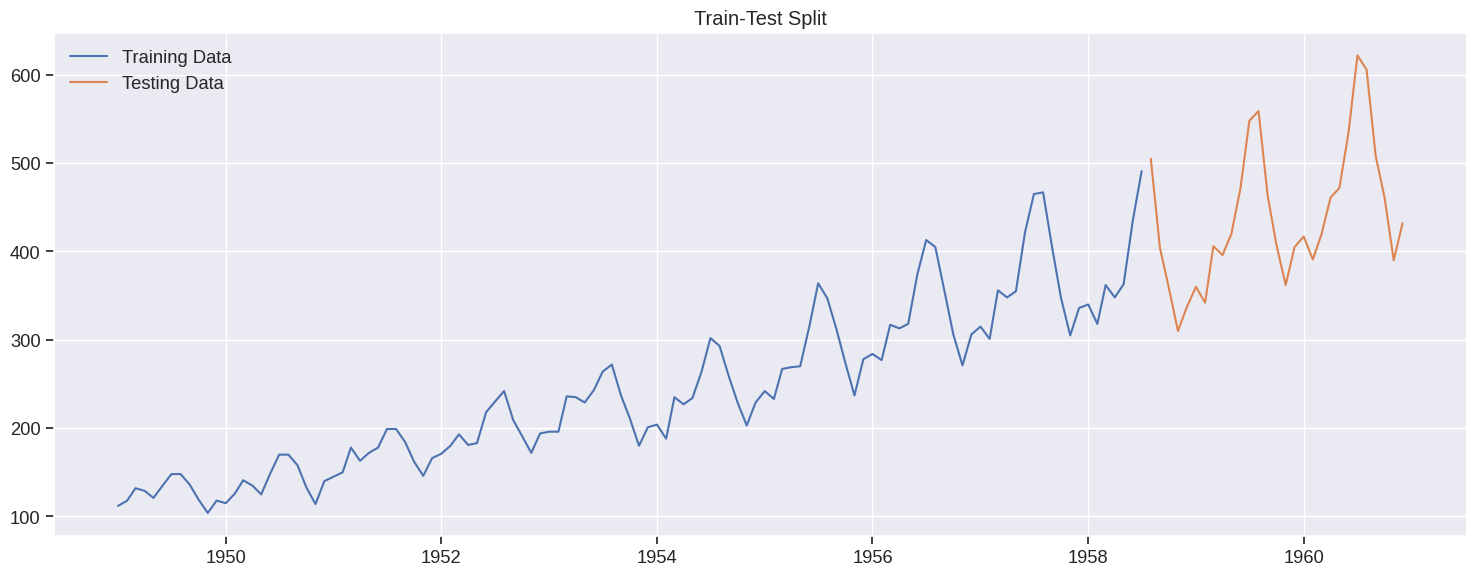

In [15]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"Training data: {train_data.index.min()} to {train_data.index.max()} ({len(train_data)} months)")
print(f"Testing data: {test_data.index.min()} to {test_data.index.max()} ({len(test_data)} months)")

# Plot the train-test split
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data')
plt.title('Train-Test Split')
plt.legend()
plt.tight_layout()
plt.show()

# 1. ARIMA Model Implementation

In [16]:
def evaluate_forecast(actual, forecast, model_name):
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, forecast)

    print(f"{model_name} Performance Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")

    return {'mse': mse, 'rmse': rmse, 'mae': mae}

In [17]:
def fit_arima(train, test, order):
    # Fit the model
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    # Get forecast
    forecast = model_fit.forecast(steps=len(test))

    # Create a DataFrame for the forecasted values
    forecast_df = pd.DataFrame(forecast, index=test.index, columns=['forecast'])

    # Print summary
    print(f"ARIMA{order} Summary:")
    print(model_fit.summary().tables[0])

    # Plot actual vs forecast
    plt.figure(figsize=(15, 6))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Actual Test Data')
    plt.plot(forecast_df, label='ARIMA Forecast', color='red')
    plt.title(f'ARIMA{order} Forecast', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluate forecast
    metrics = evaluate_forecast(test, forecast, f"ARIMA{order}")

    return model_fit, forecast_df, metrics

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2) Summary:
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  115
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -523.758
Date:                Wed, 23 Apr 2025   AIC                           1057.516
Time:                        23:17:52   BIC                           1071.197
Sample:                    01-01-1949   HQIC                          1063.069
                         - 07-01-1958                                         
Covariance Type:                  opg                                         


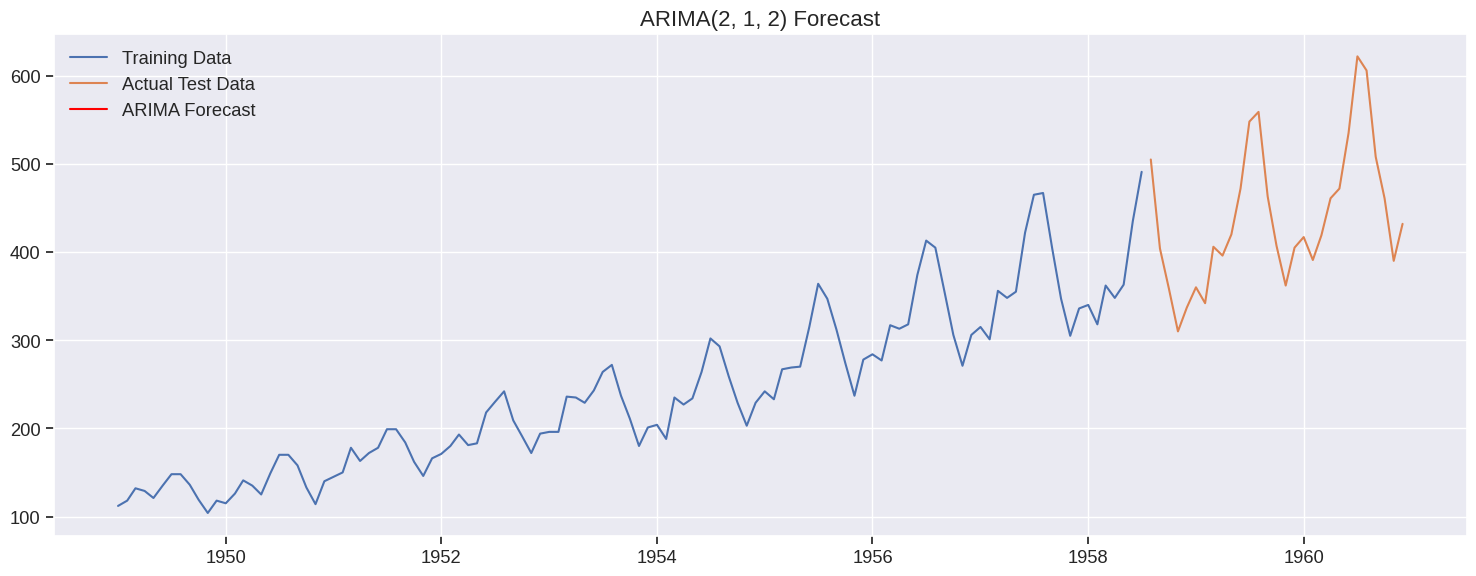

ARIMA(2, 1, 2) Performance Metrics:
MSE: 6808.40
RMSE: 82.51
MAE: 63.55


In [18]:
arima_order = (2, 1, 2)  # Based on ACF/PACF analysis

# Fit ARIMA model
arima_model, arima_forecast, arima_metrics = fit_arima(
    train_data['Passengers'],
    test_data['Passengers'],
    arima_order
)

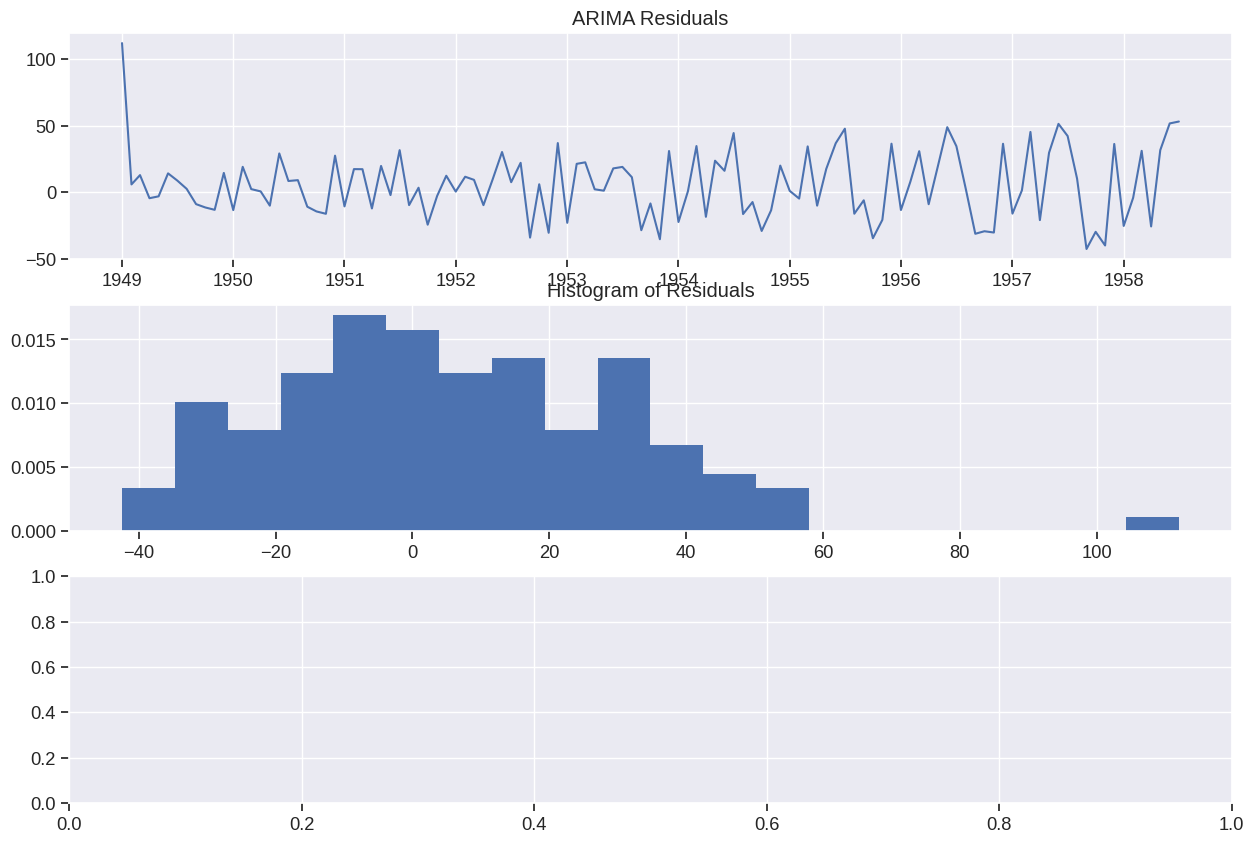

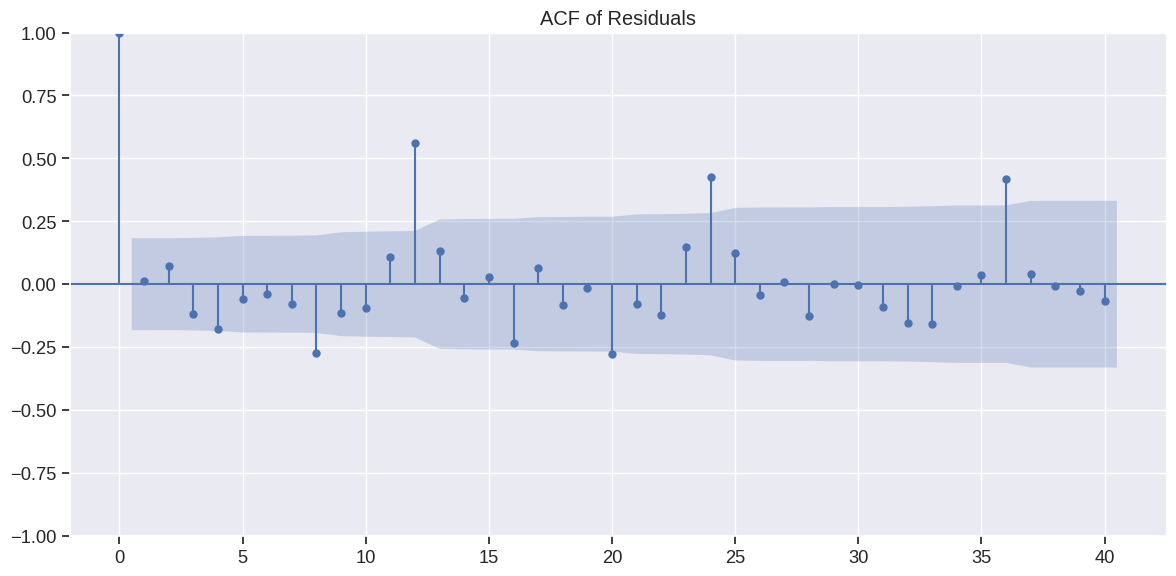

In [19]:
# Residual analysis for ARIMA
arima_residuals = arima_model.resid

plt.figure(figsize=(15, 10))

# Plot residuals
plt.subplot(3, 1, 1)
plt.plot(arima_residuals)
plt.title('ARIMA Residuals')
plt.grid(True)

# Plot residuals histogram
plt.subplot(3, 1, 2)
plt.hist(arima_residuals, bins=20, density=True)
plt.title('Histogram of Residuals')
plt.grid(True)

# Plot residuals ACF
plt.subplot(3, 1, 3)
plot_acf(arima_residuals, lags=40)
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

# 2. SARIMA Model Implementation

In [20]:
def fit_sarima(train, test, order, seasonal_order):
    # Fit the model
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)

    # Get forecast
    forecast = model_fit.forecast(steps=len(test))

    # Create a DataFrame for the forecasted values
    forecast_df = pd.DataFrame(forecast, index=test.index, columns=['forecast'])

    # Print summary
    print(f"SARIMA{order}x{seasonal_order} Summary:")
    print(model_fit.summary().tables[0])

    # Plot actual vs forecast
    plt.figure(figsize=(15, 6))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Actual Test Data')
    plt.plot(forecast_df, label='SARIMA Forecast', color='red')
    plt.title(f'SARIMA{order}x{seasonal_order} Forecast', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluate forecast
    metrics = evaluate_forecast(test, forecast, f"SARIMA{order}x{seasonal_order}")

    return model_fit, forecast_df, metrics

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 1, 1, 12) Summary:
                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -374.130
Date:                            Wed, 23 Apr 2025   AIC                            758.260
Time:                                    23:19:03   BIC                            771.385
Sample:                                01-01-1949   HQIC                           763.575
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         


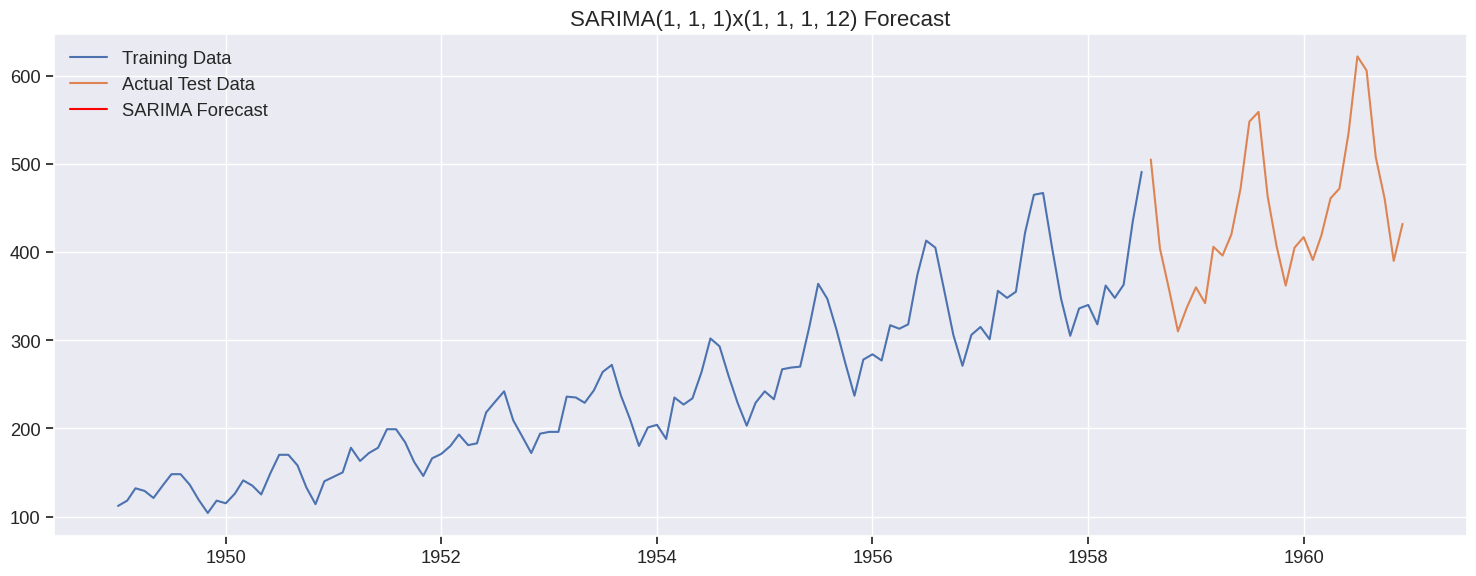

SARIMA(1, 1, 1)x(1, 1, 1, 12) Performance Metrics:
MSE: 908.35
RMSE: 30.14
MAE: 23.55


In [21]:
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Using seasonal period of 12 months

# Fit SARIMA model
sarima_model, sarima_forecast, sarima_metrics = fit_sarima(
    train_data['Passengers'],
    test_data['Passengers'],
    sarima_order,
    seasonal_order
)

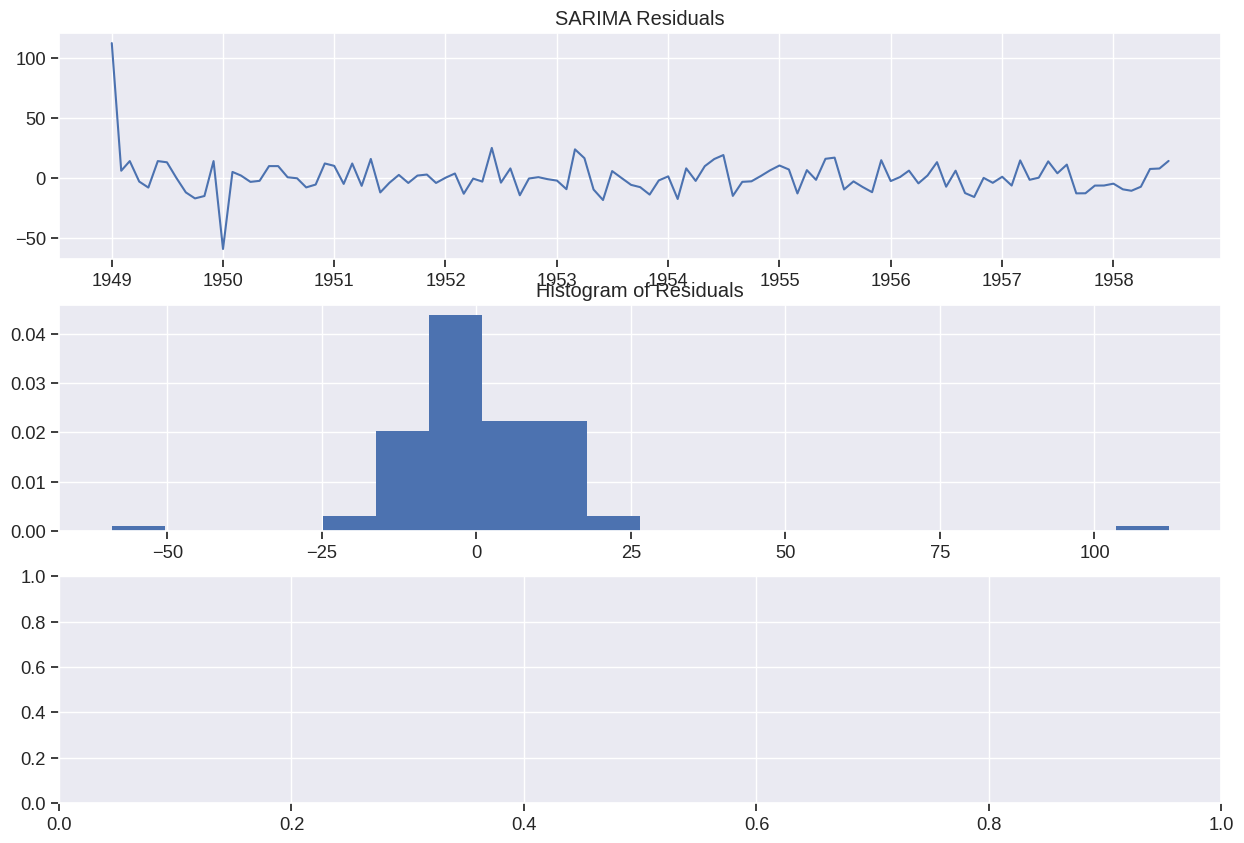

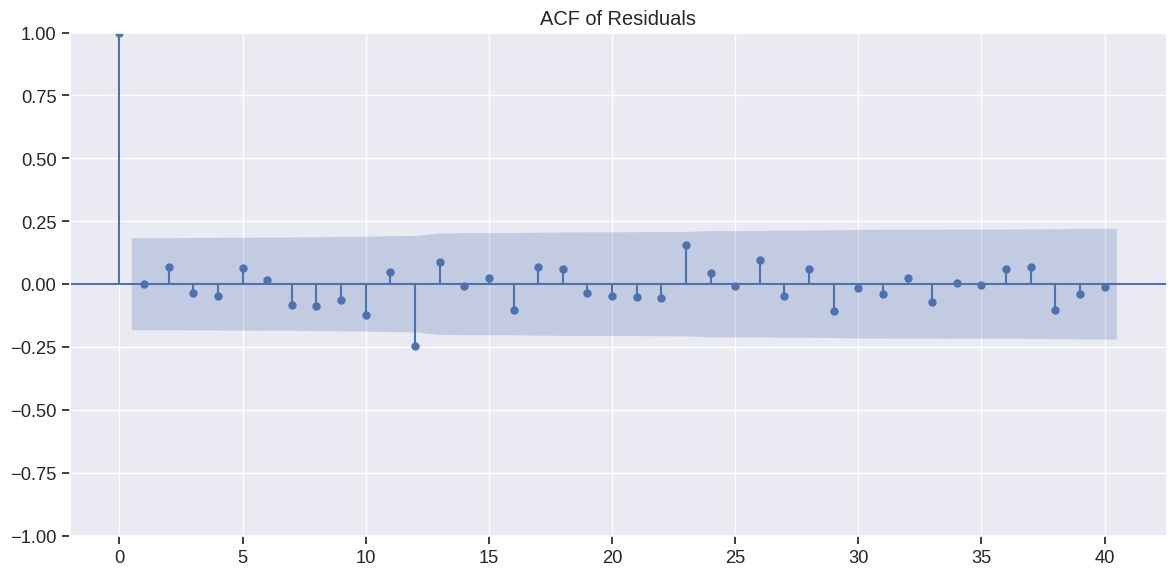

In [22]:
# Residual analysis for SARIMA
sarima_residuals = sarima_model.resid

plt.figure(figsize=(15, 10))

# Plot residuals
plt.subplot(3, 1, 1)
plt.plot(sarima_residuals)
plt.title('SARIMA Residuals')
plt.grid(True)

# Plot residuals histogram
plt.subplot(3, 1, 2)
plt.hist(sarima_residuals, bins=20, density=True)
plt.title('Histogram of Residuals')
plt.grid(True)

# Plot residuals ACF
plt.subplot(3, 1, 3)
plot_acf(sarima_residuals, lags=40)
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

# 3. LSTM Model Implementation

In [23]:
# Function to prepare data for LSTM
def prepare_data_for_lstm(dataset, look_back=1):
    """
    Convert an array of values into a dataset matrix for LSTM.
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Data preprocessing for LSTM
def prepare_lstm_data(train, test, look_back):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Reshape and scale train data
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

    # Reshape and scale test data
    test_scaled = scaler.transform(test.values.reshape(-1, 1))

    # Prepare train data for LSTM
    X_train, y_train = prepare_data_for_lstm(train_scaled, look_back)

    # Reshape input to be [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Prepare test data for LSTM
    X_test, y_test = prepare_data_for_lstm(test_scaled, look_back)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, y_train, X_test, y_test, scaler

In [24]:
def create_lstm_model(look_back):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [25]:
# Set the look_back parameter
look_back = 12  # Using 12 months as the look-back period

# Prepare data for LSTM
X_train, y_train, X_test, y_test, scaler = prepare_lstm_data(
    train_data['Passengers'],
    test_data['Passengers'],
    look_back
)

In [26]:
# Create and train the LSTM model
lstm_model = create_lstm_model(look_back)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training LSTM model...")
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Training LSTM model...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - loss: 0.1331 - val_loss: 0.2994
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0648 - val_loss: 0.1304
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0215 - val_loss: 0.0314
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0120 - val_loss: 0.0380
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0240 - val_loss: 0.0335
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0199 - val_loss: 0.0244
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0122 - val_loss: 0.0357
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0115 - val_loss: 0.0480
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0128 - val_loss: 0.0470
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0168 - val_loss: 0.0364
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0102 - val_loss: 0.0273
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

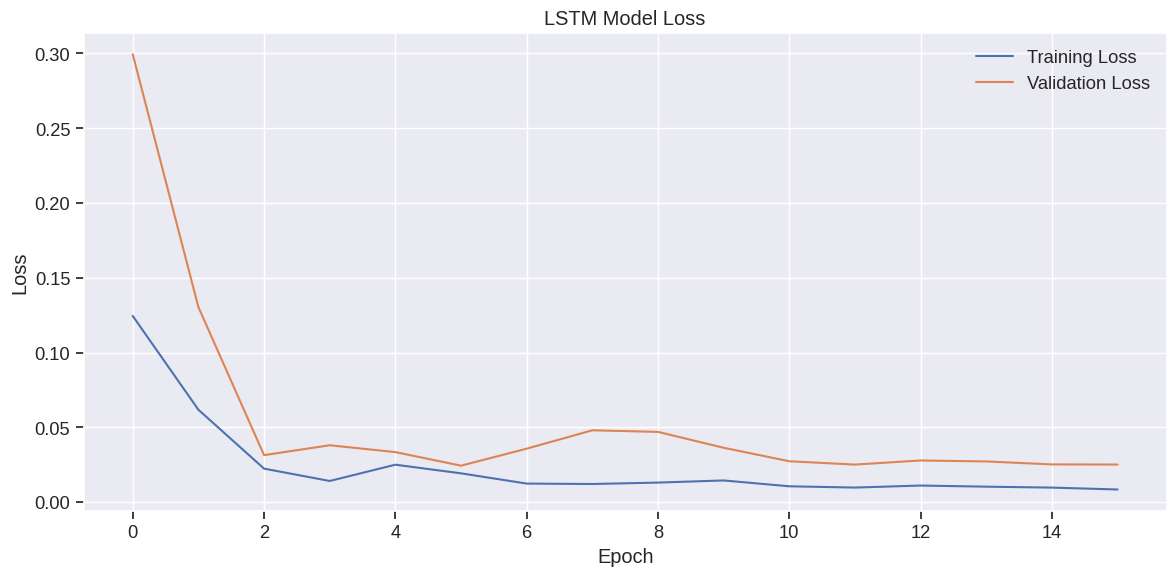

In [27]:
# Plot LSTM training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Make predictions using the LSTM model
def predict_lstm(model, X, scaler):
    # Make predictions
    predictions = model.predict(X)

    # Inverse transform to original scale
    predictions = scaler.inverse_transform(predictions)

    return predictions

# Get predictions
lstm_predictions = predict_lstm(lstm_model, X_test, scaler)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step


In [30]:
# Create a DataFrame for actual and predicted values
lstm_results = pd.DataFrame(index=test_data.index[look_back:])
lstm_results['Actual'] = test_data['Passengers'].values[look_back:]
lstm_results['LSTM_Predicted'] = lstm_predictions

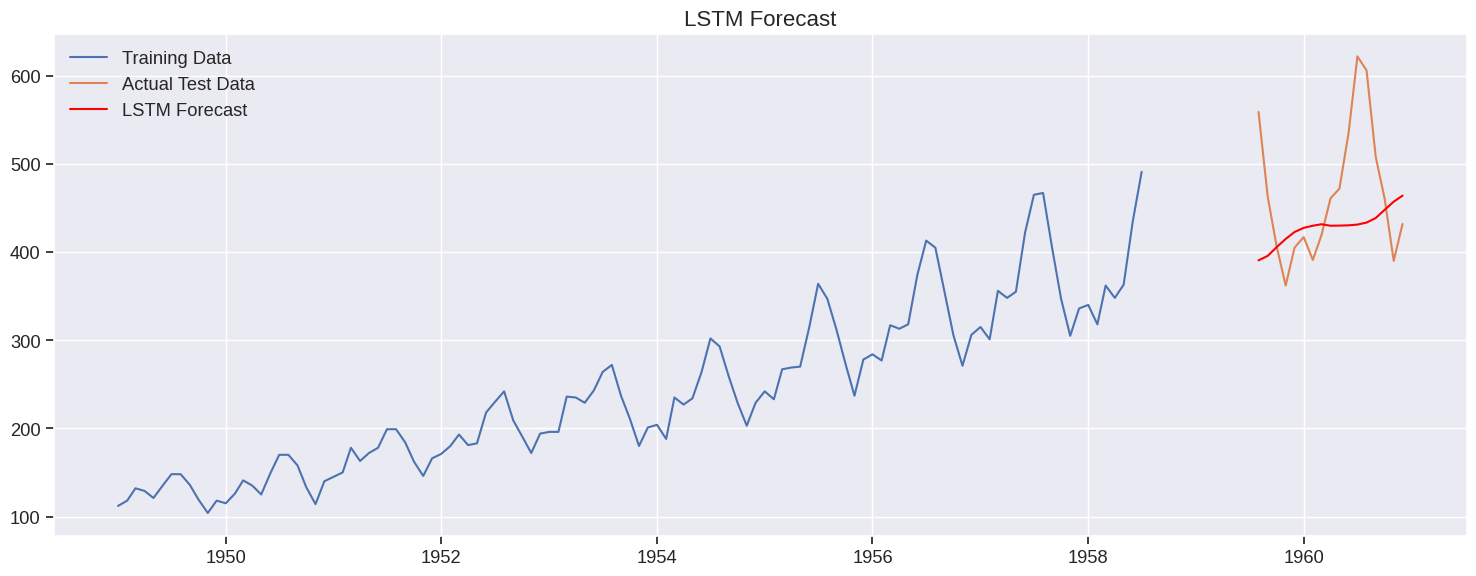

In [31]:
# Plot actual vs predicted
plt.figure(figsize=(15, 6))
plt.plot(train_data['Passengers'], label='Training Data')
plt.plot(lstm_results['Actual'], label='Actual Test Data')
plt.plot(lstm_results.index, lstm_results['LSTM_Predicted'], label='LSTM Forecast', color='red')
plt.title('LSTM Forecast', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Evaluate LSTM forecast
lstm_metrics = evaluate_forecast(
    lstm_results['Actual'],
    lstm_results['LSTM_Predicted'],
    "LSTM"
)

LSTM Performance Metrics:
MSE: 7540.50
RMSE: 86.84
MAE: 64.28
